In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import max_error
import numpy as np

In [ ]:
data = pd.read_pickle(r"../data/B00020S.pkl")
data['Date'] = pd.to_datetime(data['Date'])

# TODO
 - znaleźć prawidłowe offset_values — Max **DONE**
 - wykresy błędów — Adam
 - nałożyć wartość bezwzględną na histogram błędu bezwzględnego — Adam
 - upiększyć wykresy — Max
 - dodać do temp kolumnę z datami — Max
 - może jakiś opis matematyczny w markdownie tej regresji czy coś — Max albo Adam
 - zautomatyzować dobór offset_values - Max

In [20]:
# Stacje
stations = ['GŁOGÓW', 'ŚCINAWA', 'MALCZYCE', 'BRZEG DOLNY', 'OŁAWA', 'BRZEG', 'RACIBÓRZ-MIEDONIA', 'KRZYŻANOWICE', 'OLZA', 'CHAŁUPKI']

# Lista różnic w dniach między Głogowem a kolejną stacją
offset_values = [0, 1, 1, 1, 2, 2, 3, 3, 3, 3]

# Rok, od którego chcemy trenować i testować model
start_year = 2019

# Grupowanie po dniach i stacjach
data_grouped = data.groupby(['Date', 'Station'])['B00020S'].mean().reset_index()

# Osobny dataframe dla każdej stacji i tylko rekordy od danego roku
station_datas = [data_grouped[(data_grouped['Station'] == station) & (data_grouped['Date'].dt.year >= start_year)].reset_index() for station in stations]

# Połączenie kolumn z poziomem wody z każdej stacji w jeden dataframe
temp = pd.concat([station_data['B00020S'] for station_data in station_datas], axis='columns').reset_index(drop=True)

# Zmiana nazw kolumn
temp.columns = stations

# Przesunięcie każdej kolumny o odpowiednią liczbę dni
for i, col in enumerate(temp.columns):
    temp[col] = temp[col].shift(periods=-offset_values[i])

# Usunięcie NA, możliwe, że później można to dopracować
temp = temp.dropna()

# Zmienne służące do podziału zbioru danych na zbiór treningowy i zbiór testujący
test_proportion = 0.2
train_proportion = 1 - test_proportion
split_point = int(len(temp) * train_proportion)

# Podział na zbiór treningowy i zbiór testowy
train_data, test_data = temp.iloc[:split_point], temp.iloc[split_point:]

# Zmienne niezależne
x = train_data.iloc[:, 1:]
x = sm.add_constant(x)

# Zmienna niezależna
y = train_data.iloc[:, 0]

# Dopasowanie modelu
model = sm.OLS(y, x).fit()

# Podsumowanie
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 GŁOGÓW   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     2095.
Date:                Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:17:08   Log-Likelihood:                -6066.1
No. Observations:                1383   AIC:                         1.215e+04
Df Residuals:                    1373   BIC:                         1.220e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               140.0133      4.45

## Resztki modelu

                  0
count  1.383000e+03
mean   3.337444e-14
std    1.944578e+01
min   -1.303481e+02
25%   -9.398465e+00
50%   -6.074235e-02
75%    8.901180e+00
max    1.057603e+02


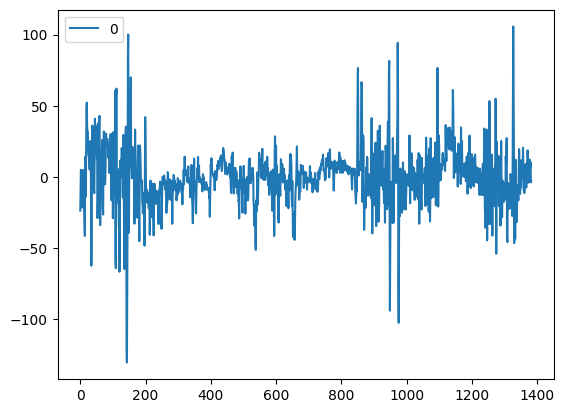

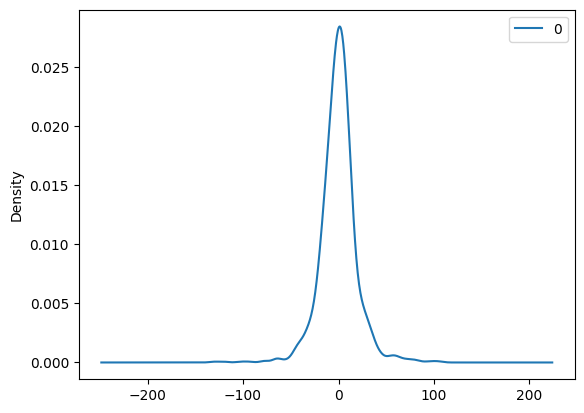

In [21]:
# Dataframe z resztami modelu
residuals = pd.DataFrame(model.resid)

# Wykres reszt
residuals.plot()

# Wykres gęstości jądra reszt / rozkład prawdopodobieństwa reszt
residuals.plot(kind='kde')

# Statystyki opisowe reszt
print(residuals.describe())

## Predykcja modelu

In [22]:
# Przewidywanie wartości na podstawie modelu
model.predict(x)

# To samo co wyżej, ale ręcznie
test_predict = model.params['const'] + sum(model.params[param] * test_data[param] for param in model.params.index[1:])

## Metryki błędu

In [23]:
# Prawdziwe dane testowe
y_true = test_data.iloc[:, 0]

# Błąd średniokwadratowy
mse = mean_squared_error(y_true=y_true, y_pred=test_predict, squared=True)

# Pierwiastek z błędu kwadratowego
rmse = mean_squared_error(y_true=y_true, y_pred=test_predict, squared=False)

# Błąd procentowy średniokwadratowy
mape = mean_absolute_percentage_error(y_true=y_true, y_pred=test_predict)

# Maksymalny błąd bezwzględny
max_absolute_error = max_error(y_true=y_true, y_pred=test_predict)

# Maksymalny błąd względny
max_relative_error = max(abs((train_data['GŁOGÓW'] - test_predict) / test_data['GŁOGÓW']))

# Bezwzględny błąd treningowy
train_absolute_error = abs(train_data['GŁOGÓW'] - test_predict)

# Względny błąd treningowy
train_relative_error = abs((train_data['GŁOGÓW'] - model.predict()) / train_data['GŁOGÓW'])

# Bezwzględny błąd testowy
test_absolute_error = abs(test_data['GŁOGÓW'] - test_predict)

# Względny błąd testowy
test_relative_error = abs((test_data['GŁOGÓW'] - test_predict) / test_data['GŁOGÓW'])

# Wyświetlenie niektórych powyższych metryk
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test max error: %.3f' % max_absolute_error)
print('Test max relative error: %.5f' % max_relative_error)

Test MSE: 536.843
Test RMSE: 23.170
Test MAPE: 0.063
Test max error: 99.933
Test max relative error: nan


## Wykresy predykcji, błędu bezwzględnego i błędu względnego

ValueError: x and y must have same first dimension, but have shapes (1383,) and (1729,)

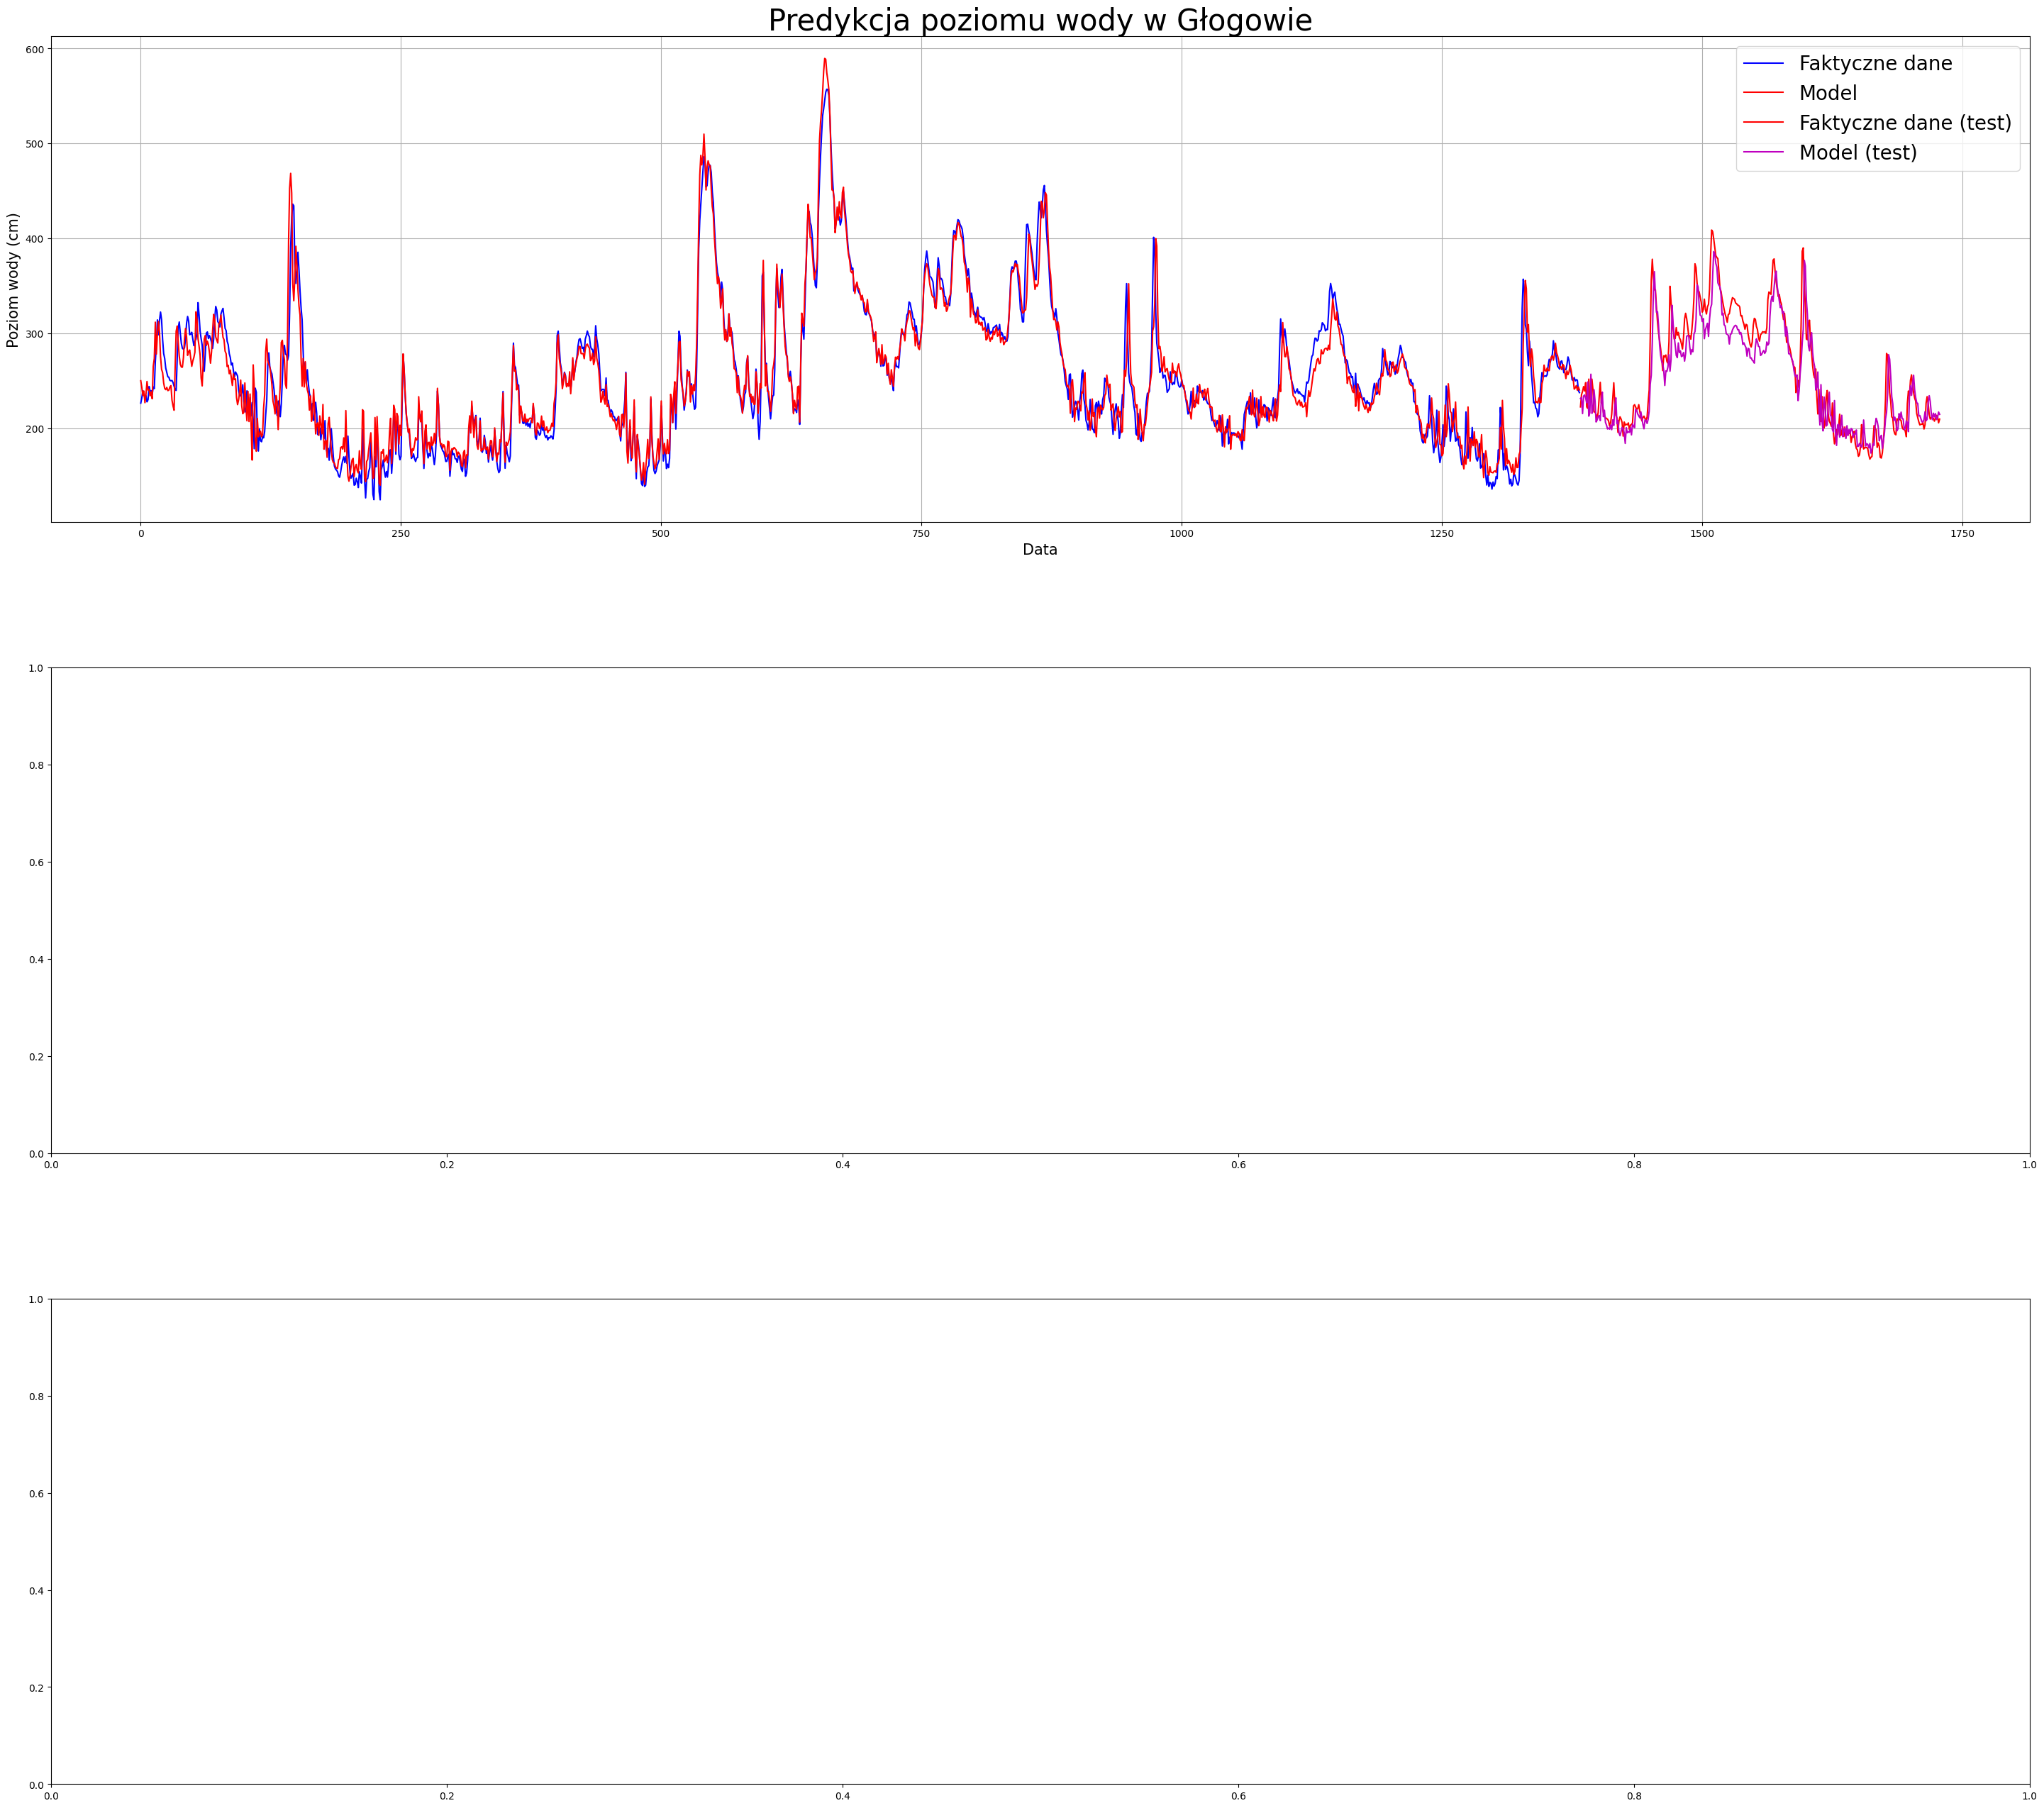

In [24]:
# Tymczasowa oś X, trzeba będzie zmienić na prawdziwą datę
date_train = np.arange(0, len(train_data))
date_test = np.arange(len(train_data), len(train_data) + len(test_data))

# Okno wykresów
fig, axes = plt.subplots(figsize=(36, 32), nrows=3, ncols=1, gridspec_kw={'hspace': 0.3})

# Wykres predykcji
axes[0].plot(date_train, train_data['GŁOGÓW'], color='b', label='Faktyczne dane')
axes[0].plot(date_train, model.predict(), 'r', label='Model')
axes[0].plot(date_test, test_data['GŁOGÓW'], color='r', label='Faktyczne dane (test)')
axes[0].plot(date_test, test_predict, color='m', label='Model (test)')
axes[0].set_xlabel('Data', fontsize=15)
axes[0].set_ylabel('Poziom wody (cm)', fontsize=15)
axes[0].set_title('Predykcja poziomu wody w Głogowie', fontsize=30)
axes[0].legend(loc='upper right', fontsize=20)
axes[0].grid()

# Wykres błędu bezwzględnego
axes[1].plot(date_train, train_absolute_error, color='b', label='Błąd bezwzględny') # ValueError: x and y must have same first dimension, but have shapes (1383,) and (1729,)
axes[1].plot(date_test, test_absolute_error, color='r', label='Błąd bezwzględny (test)')
axes[1].set_xlabel('Data', fontsize=15)
axes[1].set_ylabel('Błąd bezwzględny', fontsize=15)
axes[1].set_title('Błąd bezwzględny', fontsize=30)
axes[1].legend(loc='upper right', fontsize=20)
axes[1].grid()

# Wykres błędu względnego
axes[2].plot(date_train, train_relative_error, color='b', label='Błąd względny')
axes[2].plot(date_test, test_relative_error, color='r', label='Błąd względny (test)')
axes[2].set_xlabel('Data', fontsize=15)
axes[2].set_ylabel('Błąd względny', fontsize=15)
axes[2].set_title('Błąd względny', fontsize=30)
axes[2].legend(loc='upper right', fontsize=20)
axes[2].grid()

# Wyświetlenie wykresów
fig.show()

## Korelacje Pearsona między stacjami

In [25]:
# Funkcja do liczenia korelacji Pearsona między dwiema stacjami
def correlation_between_stations(station_1, station_2, lag):
    station_1_id = stations.index(station_1.upper())
    station_2_id = stations.index(station_2.upper())
    correlation = lagged_dfs[lag][station_1_id]['B00020S'].corr(lagged_dfs[0][station_2_id]['B00020S'])
    return round(correlation, 3)

# Stacje
stations = ['GŁOGÓW', 'ŚCINAWA', 'MALCZYCE', 'BRZEG DOLNY', 'OŁAWA', 'BRZEG', 'RACIBÓRZ-MIEDONIA', 'KRZYŻANOWICE', 'OLZA', 'CHAŁUPKI']

# Grupowanie po dniach i stacjach
data_grouped = data.groupby(['Date', 'Station'])['B00020S'].mean().reset_index()

# Maksymalny lag
max_lag = 7

# Lista od 0 do max_lag
lags = range(max_lag + 1)

# Dwuwymiarowa lista zlagowanych dataframe'ów stacji
# Dostęp do wybranej stacji i lagu: lagged_dfs[lag][id_stacji np. 0 dla Głogowa]
start_date = '2008-01-08'
end_date = '2023-09-30'
lagged_dfs =[[data_grouped[(data_grouped['Date']
                .between(
                    pd.to_datetime(start_date) - pd.DateOffset(days=lag),
                    pd.to_datetime(end_date) - pd.DateOffset(days=lag)
                ))&(data_grouped['Station'] == station)].reset_index(drop=True) for station in stations]for lag in lags
             ]
# Lista stacji, dla których chcemy obliczyć korelację Pearsona względem Głogowa
stations_to_calculate_corr = ['ŚCINAWA', 'MALCZYCE']

# Wyświetlanie korelacji Pearsona
for station in stations_to_calculate_corr:
    print(f"\nWspółczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: {station.capitalize()} - Głogów")
    for lag in lags:
        print(f"Lag: {lag}, p = {correlation_between_stations(station, 'Głogów', lag)}")


Współczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: Ścinawa - Głogów
Lag: 0, p = 0.902
Lag: 1, p = 0.903
Lag: 2, p = 0.883
Lag: 3, p = 0.859
Lag: 4, p = 0.834
Lag: 5, p = 0.809
Lag: 6, p = 0.786
Lag: 7, p = 0.765

Współczynnik korelacji Pearsona liczony na podstawie poziomu wody w stacjach: Malczyce - Głogów
Lag: 0, p = 0.892
Lag: 1, p = 0.923
Lag: 2, p = 0.934
Lag: 3, p = 0.93
Lag: 4, p = 0.912
Lag: 5, p = 0.884
Lag: 6, p = 0.854
Lag: 7, p = 0.827
